# Analysis of DrugBank Data
**Author:** Bartosz Czechowski (bc458939)  
**Contact:** b.czechowski@student.uw.edu.pl  
**Context:** Created as part of the Python Programming Course at MIMUW (2024/25 Winter Semester)

## Prerequisites

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [202]:
import os

FILE_NAME = os.path.join('data', 'drugbank_partial.xml')

# namespace
ns = {
    "db": "http://www.drugbank.ca", 
}

# Does not parse nested field correctly (e.g. groups)
df = pd.read_xml(
    FILE_NAME,  # Replace with your XML file path
)
df

,type,created,updated,drugbank-id,name,description,cas-number,unii,state,groups,...,snp-adverse-drug-reactions,targets,enzymes,carriers,transporters,fda-label,msds,average-mass,monoisotopic-mass,calculated-properties
0,biotech,2005-06-13,2024-01-02,BIOD00024,Lepirudin,Lepirudin is a recombinant hirudin formed by 6...,138068-37-8,Y43GF64R34,solid,\n,...,None,\n,None,None,None,None,None,NaN,NaN,None
1,biotech,2005-06-13,2024-01-02,BIOD00071,Cetuximab,Cetuximab is a recombinant chimeric human/mous...,205923-56-4,PQX0D8J21J,liquid,\n,...,None,\n,None,None,None,//s3-us-west-2.amazonaws.com/drugbank/fda_labe...,//s3-us-west-2.amazonaws.com/drugbank/msds/DB0...,NaN,NaN,None
2,biotech,2005-06-13,2024-03-13,BIOD00001,Dornase alfa,Dornase alfa is a biosynthetic form of human d...,143831-71-4,953A26OA1Y,liquid,\n,...,None,\n,None,None,None,//s3-us-west-2.amazonaws.com/drugbank/fda_labe...,//s3-us-west-2.amazonaws.com/drugbank/msds/DB0...,NaN,NaN,None
3,biotech,2005-06-13,2024-01-02,BIOD00084,Denileukin diftitox,A recombinant DNA-derived cytotoxic protein co...,173146-27-5,25E79B5CTM,liquid,\n,...,None,\n,None,None,None,//s3-us-west-2.amazonaws.com/drugbank/fda_labe...,None,NaN,NaN,None
4,biotech,2005-06-13,2024-02-02,BIOD00052,Etanercept,Dimeric fusion protein consisting of the extra...,185243-69-0,OP401G7OJC,liquid,\n,...,None,\n,None,None,None,None,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,biotech,2005-06-13,2024-03-13,BIOD00088,Octreotide,Acromegaly is a disorder caused by excess grow...,83150-76-9,RWM8CCW8GP,solid,\n,...,None,\n,\n,\n,\n,//s3-us-west-2.amazonaws.com/drugbank/fda_labe...,None,NaN,NaN,None
96,biotech,2005-06-13,2024-03-13,DB05600,Interferon alfa-2b,Interferon alpha 2b (human leukocyte clone hif...,98530-12-2,43K1W2T1M6,liquid,\n,...,None,\n,\n,None,None,//s3-us-west-2.amazonaws.com/drugbank/fda_labe...,None,NaN,NaN,None
97,small molecule,2005-06-13,2024-01-02,BIOD00051,Abarelix,Synthetic decapeptide antagonist to gonadotrop...,183552-38-7,W486SJ5824,solid,\n,...,None,\n,None,None,None,//s3-us-west-2.amazonaws.com/drugbank/fda_labe...,None,1416.09,1414.684072,\n
98,biotech,2005-06-13,2024-03-13,BIOD00016,Oxytocin,Sir Henry H. Dale first identified oxytocin an...,50-56-6,1JQS135EYN,liquid,\n,...,None,\n,\n,\n,\n,None,None,NaN,NaN,None


In [203]:
import xml.etree.ElementTree as ET

# Parse XML file
et_tree = ET.parse(FILE_NAME)
et_root = et_tree.getroot()

def text_or_none(element):
    return element.text if element is not None else None

# We treat name as the primary key because it is unique and since one drug has multiple ids its problematic
def extract_nested(nested_path, column_name='nested'):
    nested_data = []
    for drug in et_root.findall("db:drug", ns):
        id = text_or_none(drug.find("db:drugbank-id[@primary='true']", ns))
        if id is None:
            continue
        name = text_or_none(drug.find("db:name", ns))
        if name is None:
            continue
        current_el = [
            text_or_none(e) for e in drug.findall(nested_path, ns)
        ]
        nested_data.append({
            "name": name,
            column_name: current_el,
        })
    
    return pd.DataFrame(nested_data)


## 1. Drug Information DataFrame

In [204]:
# all the simple fields
drug_info_df = df[['drugbank-id', 'name', 'type', 'description', 'state', 'indication',
                   'mechanism-of-action']]
# and the nested food interactions
food_interactions_df = extract_nested("db:food-interactions/db:food-interaction", 'food-interactions')

# merge the two dataframes
drug_info_df = pd.merge(drug_info_df, food_interactions_df, on='name', how='inner')
drug_info_df

# NOTE : we choose an arbitrary drugbank-id since it was not specified in the tast

,drugbank-id,name,type,description,state,indication,mechanism-of-action,food-interactions
0,BIOD00024,Lepirudin,biotech,Lepirudin is a recombinant hirudin formed by 6...,solid,Lepirudin is indicated for anticoagulation in ...,Lepirudin is a direct thrombin inhibitor used ...,[Avoid herbs and supplements with anticoagulan...
1,BIOD00071,Cetuximab,biotech,Cetuximab is a recombinant chimeric human/mous...,liquid,Cetuximab indicated for the treatment of local...,The epidermal growth factor receptor (EGFR) is...,[]
2,BIOD00001,Dornase alfa,biotech,Dornase alfa is a biosynthetic form of human d...,liquid,Used as adjunct therapy in the treatment of cy...,Dornase alfa is a biosynthetic form of human D...,[]
3,BIOD00084,Denileukin diftitox,biotech,A recombinant DNA-derived cytotoxic protein co...,liquid,For treatment of cutaneous T-cell lymphoma,Denileukin diftitox binds to the high-affinity...,[]
4,BIOD00052,Etanercept,biotech,Dimeric fusion protein consisting of the extra...,liquid,Etanercept is indicated for the treatment of m...,There are two distinct receptors for TNF (TNFR...,[]
...,...,...,...,...,...,...,...,...
95,BIOD00088,Octreotide,biotech,Acromegaly is a disorder caused by excess grow...,solid,Octreotide by injection is used for the treatm...,Octreotide binds to somatostatin receptors cou...,[Take on an empty stomach. The oral capsules s...
96,DB05600,Interferon alfa-2b,biotech,Interferon alpha 2b (human leukocyte clone hif...,liquid,"For the treatment of hairy cell leukemia, mali...",Interferon alpha binds to type I interferon re...,[Avoid alcohol.]
97,BIOD00051,Abarelix,small molecule,Synthetic decapeptide antagonist to gonadotrop...,solid,For palliative treatment of advanced prostate ...,Abarelix binds to the gonadotropin releasing h...,[]
98,BIOD00016,Oxytocin,biotech,Sir Henry H. Dale first identified oxytocin an...,liquid,Administration of exogenous oxytocin is indica...,Oxytocin plays a vital role in labour and deli...,[]


## 2. Synonyms dataframe and graph

In [205]:
# First create a dataframe mapping a drugbank-id to a name since names are easier to work with

def id_name():
    data = dict()
    for drug in et_root.findall("db:drug", ns):
        ids = drug.findall("db:drugbank-id", ns)
        if len(ids) == 0:
            continue
        ids = [id.text for id in ids]
        name = drug.find("db:name", ns).text
        for id in ids:
            data[id] = name

    dfdict = {"id": [], "name": []}
    for k, v in data.items():
        dfdict["id"].append(k)
        dfdict["name"].append(v)
         
    return pd.DataFrame(dfdict)

id_name_df = id_name()
id_name_df

,id,name
0,DB00001,Lepirudin
1,BTD00024,Lepirudin
2,BIOD00024,Lepirudin
3,DB00002,Cetuximab
4,BTD00071,Cetuximab
...,...,...
332,BTD00016,Oxytocin
333,BIOD00016,Oxytocin
334,DB00108,Natalizumab
335,BTD00083,Natalizumab


In [191]:
# then connect id to synonyms list
id_to_synonyms_df = extract_nested("db:synonyms/db:synonym", 'synonyms')
id_to_synonyms_df = pd.merge(id_name_df, id_to_synonyms_df, on='name', how='inner')
id_to_synonyms_df

,id,name,synonyms
0,DB00001,Lepirudin,"[[Leu1, Thr2]-63-desulfohirudin, Desulfatohiru..."
1,BTD00024,Lepirudin,"[[Leu1, Thr2]-63-desulfohirudin, Desulfatohiru..."
2,BIOD00024,Lepirudin,"[[Leu1, Thr2]-63-desulfohirudin, Desulfatohiru..."
3,DB00002,Cetuximab,"[Cetuximab, Cétuximab, Cetuximabum]"
4,BTD00071,Cetuximab,"[Cetuximab, Cétuximab, Cetuximabum]"
...,...,...,...
332,BTD00016,Oxytocin,"[Oxitocina, Oxytocin]"
333,BIOD00016,Oxytocin,"[Oxitocina, Oxytocin]"
334,DB00108,Natalizumab,"[Anti-alpha4 integrin, Anti-VLA4, IMMUNOGLOBUL..."
335,BTD00083,Natalizumab,"[Anti-alpha4 integrin, Anti-VLA4, IMMUNOGLOBUL..."


In [161]:
import networkx as nx

def print_synonyms(drug_id, fixed_seed = None):
    row = id_to_synonyms_df[id_to_synonyms_df["id"] == drug_id]
    if row.empty:
        print(f"Drug with id {drug_id} not found")
        return
    name = row["name"].iloc[0]
    synonyms = row["synonyms"].iloc[0]
    synonyms = [syn for syn in synonyms if syn != name]

    G = nx.Graph()
    nx.add_star(G, [name] + synonyms)

    node_colors = ['red' if node == name else 'blue' for node in G.nodes()]
    
    pos = nx.spring_layout(G, seed=fixed_seed)
    
    # Draw the graph without labels
    nx.draw(
        G,
        pos,
        with_labels=False,  # Turn off the default labels
        node_color=node_colors,
        node_size=1000,  # Node size
        edge_color="gray",
    )
    
    # Draw labels as nodes
    for node, (x, y) in pos.items():
        plt.scatter(x, y, s=1000, color='white', edgecolor='black', zorder=3)
        plt.text(
            x, y,
            node,
            fontsize=10,
            ha='center',
            va='center',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.3')
        )
    
    plt.title("Synonyms Graph", fontsize=14)
    plt.axis('off')  # Hide axes
    plt.show()

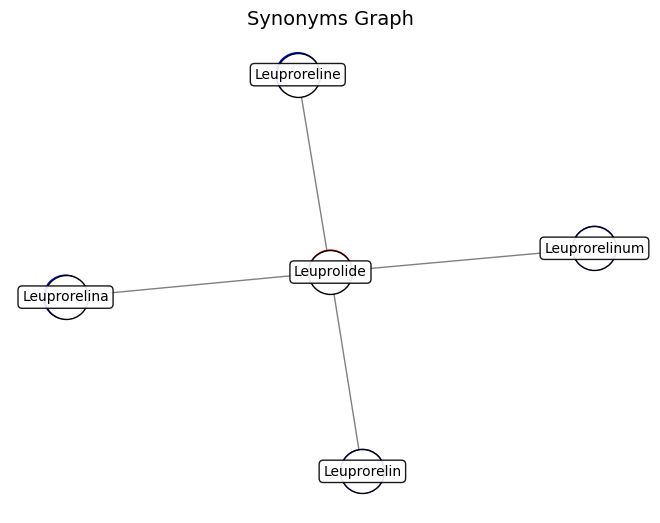

In [207]:
DRUG_ID = "DB00007"
print_synonyms(DRUG_ID)

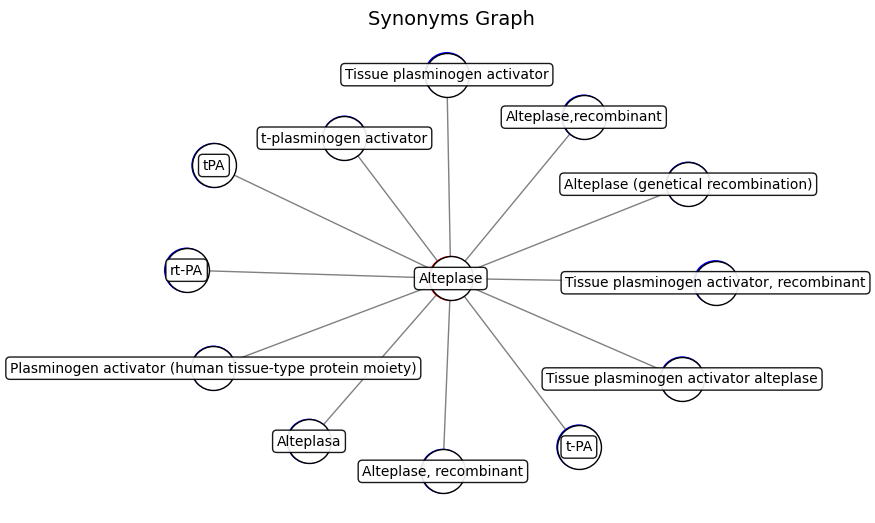

In [210]:
DRUG_ID = "DB00009"
# for large graphs some seeds can make long names overlap,
# so we fix (and possibly tweak) the seed to reduce the chance of that happening
print_synonyms(DRUG_ID, 420) 

## 3. Pharmaceutical products

In [211]:
# somewhat similar to extract_nested but not worth refactoring
def extract_nested_product():
    nested_data = []
    for drug in et_root.findall("db:drug", ns):
        id = text_or_none(drug.find("db:drugbank-id[@primary='true']", ns))
        if id is None:
            continue
        name = text_or_none(drug.find("db:name", ns))
        if name is None:
            continue
        
        
        for product in drug.findall('db:products/db:product', ns):
            product_name = text_or_none(product.find('db:name', ns))
            labeller = text_or_none(product.find('db:labeller', ns))
            # for non-us drugs this will be empty
            ndc_product_code = text_or_none(product.find('db:ndc-product-code', ns))
            dosage_form = text_or_none(product.find('db:dosage-form', ns))
            route = text_or_none(product.find('db:route', ns))
            # im not sure if strength is what is asked for but it's the best fit
            strength = text_or_none(product.find('db:strength', ns))
            country = text_or_none(product.find('db:country', ns))
            source = text_or_none(product.find('db:source', ns))

            nested_data.append({
                "id": id,
                "product_name": product_name,
                "labeller": labeller,
                "ndc_product_code": ndc_product_code,
                "dosage_form": dosage_form,
                "route": route,
                "strength": strength,
                "country": country,
                "source": source,
            })
            
    return pd.DataFrame(nested_data)

product_df = extract_nested_product()
product_df

,id,product_name,labeller,ndc_product_code,dosage_form,route,strength,country,source
0,DB00001,Refludan,Bayer,50419-150,Powder,Intravenous,50 mg/1mL,US,FDA NDC
1,DB00001,Refludan,Bayer,None,"Powder, for solution",Intravenous,50 mg / vial,Canada,DPD
2,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,50 mg,EU,EMA
3,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,50 mg,EU,EMA
4,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,20 mg,EU,EMA
...,...,...,...,...,...,...,...,...,...
4579,DB00108,Tysabri,Elan Pharmaceuticals,59075-730,Injection,Intravenous,300 mg/15mL,US,FDA NDC
4580,DB00108,Tysabri,Biogen Inc.,64406-008,Injection,Intravenous,300 mg/15mL,US,FDA NDC
4581,DB00108,Tysabri,Biogen,None,Solution,Intravenous,300 mg / 15 mL,Canada,DPD
4582,DB00108,Tysabri,Biogen Netherlands B.V.,None,"Injection, solution, concentrate",Intravenous,300 mg,EU,EMA
